# Technical Notebook

___

### Goal: Manage ad placement on social recipe app Spoonacular
We aim to more effectively target ads to Spoonacular app users. To do so, we predict which recipes will be popular - or whether or not to post an ad on the recipe's webpage. 

### Data: [Spoonacular API](https://spoonacular.com/food-api/docs)
We were able to call 1000 *unique* recipes using the Spoonacular API. Each recipe contains extensive information from nutritional content to dietary classifications. A number of "Likes" is also provided for each recipe. In lieu of webpage traffic, we use Likes as our dependent variable. From recipe information, we developed and/or utilized a total of 35 numerical predictors (indepedent variables) of Likes. The numerical data is standardized below.

As a note for future work, natural language processing may be useful to cluster text such as ingredient types - such as to predict the most visited recipe webpages with respect to the use of "avacado".

### Model: Binary Logistic Regression
#### Categorization of "Likes"
We utilize median Likes as a cutoff between well-liked recipes and those receiving low Likes.  This helps ensure that our model trains on proportional amounts of well-liked and lesser-liked recipes. 
#### Assumptions
- Dependent variable (Likes) is binary.
- Large sample size. 
 - Our data fulfills the general guideline of 10 cases with the least frequent outcome for each independent variable. In this case, p(outcome) = 0.5, and for a total of 1000 cases, we *could in some cases* utilize a maximum of 50 indepedent variables in the model.
- Observations (recipes) are independent of each other. 
 - While recipes often reference one another within another recipe (i.e. frosting for a cake), we do not osberve this on Spoonacular.
- Little or no multicollinearity among the independent variables. 
 - We understand that macro and micronutrients are likely to have high multicollinearity and test for this.
- Linearity of independent variables and log odds. 
 - In our [exploratory data analysis](https://github.com/alexwcheng/recipe-strategy/blob/master/Logistic_Regression_Final/Exploratory%20Data%20Analysis.ipynb), we see that the dependent variable, Likes, has an exponential distribution. While, there exists a linear relationship between log odds and some predictors, this is not a majority case.

___

### Import Packages, Data, and Functions

In [1]:
import sys
sys.path.append("..")

In [2]:
# Import necessary python packages and functions
from Python_Files.imports import *
%matplotlib inline

In [3]:
# Read in data
df = pd.read_csv('../Data/Recipes_raw.csv', index_col=0)

In [4]:
# Ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

### Prepare Data
Scale numerical predictors using StandardScaler and copy non-numerical predictors from original dataframe.

In [5]:
from Python_Files.data_cleaning import *
#scale_num_vars, categorize_likes, produce_roc_curve

In [6]:
# Create new dataframe containing both scaled and unscaled predictors
df_ss = scale_num_vars(df)

Categorize Likes as binary outcome using median value to equalize training.

In [7]:
# Create new column for outcome
df_ss['high_likes'] = categorize_likes(df_ss, 'aggregateLikes')
# Ensure proportional binary outcome
df_ss['high_likes'].value_counts()

1    500
0    500
Name: high_likes, dtype: int64

### Feature Selection
**1. What predictors are available?**

In [8]:
x_variables_1 = list(df_ss.columns)
x_variables_1

['cookingMinutes',
 'num_ingredients',
 'preparationMinutes',
 'pricePerServing',
 'readyInMinutes',
 'servings',
 'weightWatcherSmartPoints',
 'Calories',
 'Fat',
 'Saturated_Fat',
 'Carbohydrates',
 'Sugar',
 'Cholesterol',
 'Sodium',
 'Protein',
 'Vitamin_K',
 'Vitamin_A',
 'Vitamin_C',
 'Manganese',
 'Folate',
 'Fiber',
 'Copper',
 'Magnesium',
 'Phosphorus',
 'Vitamin_B6',
 'Potassium',
 'Vitamin_B1',
 'Iron',
 'Vitamin_B2',
 'Vitamin_E',
 'Zinc',
 'Vitamin_B5',
 'Vitamin_B3',
 'Calcium',
 'Selenium',
 'num_words_instructions',
 'num_steps_instructions',
 'aggregateLikes',
 'ingredients_list',
 'ingredient_types',
 'title',
 'spoonacularSourceUrl',
 'high_likes']

We next drop the original count of Likes ("aggregateLikes") in favor of the binary ("high_likes") as well as the text-based information in list items [-5:-1]. **This leaves us with only numerical variables to consider in our model.**

<b>Note:</b> Due to an error raised from the Statsmodels library: <i>"PerfectSeparationError: Perfect separation detected, results not available."</i> We have removed a predictor that was essentially "unsolvable" for its coefficients. The predictor <b>"num_steps_instructions"</b> is being removed for this reason.

In [9]:
# Call list of numerical independent variables by column names
numerical_variables_1 = x_variables_1
del numerical_variables_1[-6:-1]
numerical_variables_1.remove('high_likes')
numerical_variables_1.remove('num_steps_instructions')
numerical_variables_1

['cookingMinutes',
 'num_ingredients',
 'preparationMinutes',
 'pricePerServing',
 'readyInMinutes',
 'servings',
 'weightWatcherSmartPoints',
 'Calories',
 'Fat',
 'Saturated_Fat',
 'Carbohydrates',
 'Sugar',
 'Cholesterol',
 'Sodium',
 'Protein',
 'Vitamin_K',
 'Vitamin_A',
 'Vitamin_C',
 'Manganese',
 'Folate',
 'Fiber',
 'Copper',
 'Magnesium',
 'Phosphorus',
 'Vitamin_B6',
 'Potassium',
 'Vitamin_B1',
 'Iron',
 'Vitamin_B2',
 'Vitamin_E',
 'Zinc',
 'Vitamin_B5',
 'Vitamin_B3',
 'Calcium',
 'Selenium',
 'num_words_instructions']

**2. Train-test split the data 0.75:0.25.**

In [10]:
y = df_ss.high_likes
X = df_ss[numerical_variables_1]
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, stratify = y)

**3. Initialize logistic regression model using Statsmodels.**

In [11]:
X_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_const)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.624687
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             high_likes   No. Observations:                  750
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           36
Date:                Thu, 23 Jan 2020   Pseudo R-squ.:                 0.09877
Time:                        19:44:56   Log-Likelihood:                -468.52
converged:                       True   LL-Null:                       -519.86
Covariance Type:            nonrobust   LLR p-value:                 2.497e-08
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1973      0.137      1.443      0.149      -0.071       0.465
cookingMinutes               4.1266      4.090      1.009      0.313      -3.889      12.142
num_ingredients              0.0418      0.107      0.392      0.695      -0.167       0.251
preparationMinutes           0.3100      0.193      1.605      0.108      -0.069       0.688
pricePerServing              0.2148      0.147      1.461      0.144      -0.073       0.503
readyInMinutes               0.1861      0.437      0.426      0.670      -0.670       1.042
servings                     0.1357      0.112      1.217      0.224      -0.083       0.354
weightWatcherSmartPoints     0.2420      0.431      0.561      0.575      -0.603       1.087
Calories                     1.3655      2.127      0.642      0.521      -2.804       5.535
Fat                         -1.0441      1.213     -0.861      0.389      -3.421       1.333
Saturated_Fat                0.6678      0.286      2.334      0.020       0.107       1.229
Carbohydrates               -0.6696      1.032     -0.649      0.517      -2.693       1.354
Sugar                        0.1584      0.132      1.204      0.229      -0.099       0.416
Cholesterol                  0.0088      0.143      0.062      0.951      -0.271       0.289
Sodium                       0.3662      0.130      2.820      0.005       0.112       0.621
Protein                     -0.3970      0.691     -0.574      0.566      -1.752       0.958
Vitamin_K                   -0.1567      0.121     -1.291      0.197      -0.395       0.081
Vitamin_A                   -0.0354      0.096     -0.371      0.711      -0.223       0.152
Vitamin_C                   -0.1207      0.114     -1.059      0.290      -0.344       0.103
Manganese                   -0.0500      0.134     -0.373      0.709      -0.313       0.213
Folate                      -0.1499      0.131     -1.141      0.254      -0.407       0.108
Fiber                       -0.2657      0.191     -1.394      0.163      -0.639       0.108
Copper                      -0.0226      0.088     -0.258      0.796      -0.194       0.149
Magnesium                   -0.0080      0.209     -0.038      0.970      -0.417       0.401
Phosphorus                   0.0208      0.239      0.087      0.931      -0.448       0.490
Vitamin_B6                  -0.0329      0.194     -0.170      0.865      -0.412       0.346
Potassium                   -0.0006      0.169     -0.004      0.997      -0.333       0.331
Vitamin_B1                  -0.2414      0.154     -1.570      0.116      -0.543       0.060
Iron                         0.0289      0.115      0.251      0.802      -0.197       0.255
Vitamin_B2                   0.0038      0.195      0.019      0.985      -0.379       0.387
Vitamin_E                   -0.0332      0.136     -0.245      0.806      -0.299       0.232
Zinc                         0.0432      0.181      0.239      0.811      -0.31

**4. Check for multicolinearity and high p-values among predictors.**

We use an alpha/confidence level of 0.05 to accept predictors as significant correlants to the outcome. Posting ads on less popular recipe pages could potentially waste ad investments, or at least not optimize investments.

In [12]:
# Read out variance inflation factor for each predictor. 
X = df_ss[numerical_variables_1]
X = X.fillna(0)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(numerical_variables_1, vif))

[('cookingMinutes', 1.0694203145434178),
 ('num_ingredients', 1.6498865882774663),
 ('preparationMinutes', 1.2809468585342518),
 ('pricePerServing', 3.480003145789723),
 ('readyInMinutes', 1.4095735709963229),
 ('servings', 1.5583417340115544),
 ('weightWatcherSmartPoints', 26.952629405478493),
 ('Calories', 713.994715652959),
 ('Fat', 240.39097782670126),
 ('Saturated_Fat', 3.2743120129176515),
 ('Carbohydrates', 173.80034465398052),
 ('Sugar', 2.6455978626262904),
 ('Cholesterol', 3.6604362819004557),
 ('Sodium', 1.519542775018452),
 ('Protein', 77.07195156198922),
 ('Vitamin_K', 2.1632983277784765),
 ('Vitamin_A', 1.5594151807625842),
 ('Vitamin_C', 1.9674382112122224),
 ('Manganese', 2.8208443701596084),
 ('Folate', 2.8660085894390033),
 ('Fiber', 5.506085979403955),
 ('Copper', 1.5018570727924245),
 ('Magnesium', 6.986587101330752),
 ('Phosphorus', 8.611569115894659),
 ('Vitamin_B6', 5.4480634015552845),
 ('Potassium', 4.595812562292188),
 ('Vitamin_B1', 2.7089493703146563),
 ('Ir

In [13]:
# Based on VIF of all variables, drop all predictors where VIF > 8 
unwanted = {'Calories', 'Carbohydrates', 'Sugar', 'Cholesterol', }
numerical_variables_2 = [e for e in x_variables_1 if e not in unwanted]

# Drop all predictors where p value > 0.3 after first logistic regression
numerical_variables_3 = ['num_ingredients', 'pricePerServing', 'readyInMinutes', 'servings', 
                 'Saturated_Fat', 'Sodium', 'Vitamin_K', 'Vitamin_C', 'Fiber', 'Vitamin_B1',
                'Selenium']

# After dropping these variables, all VIF scores < 3

# Drop all predictors where p value > 0.1 after second logistic regression
numerical_variables_4 = ['num_ingredients', 'pricePerServing', 'readyInMinutes', 
                 'Saturated_Fat', 'Sodium', 'Vitamin_K', 'Vitamin_C', 'Fiber']

# Drop all predictors where p value > 0.1 after third logistic regression
numerical_variables_5 = ['num_ingredients', 'readyInMinutes', 
                 'Saturated_Fat', 'Sodium', 'Vitamin_K', 'Fiber']

**5. Run model using selected features.**

In [14]:
y = df_ss.high_likes
X = df_ss[numerical_variables_5]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, stratify = y)

# Print preliminary results
X_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_const)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.639949
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             high_likes   No. Observations:                  750
Model:                          Logit   Df Residuals:                      743
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jan 2020   Pseudo R-squ.:                 0.07675
Time:                        19:44:58   Log-Likelihood:                -479.96
converged:                       True   LL-Null:                       -519.86
Covariance Type:            nonrobust   LLR p-value:                 3.934e-15
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0747      0.080      0.931      0.352      -0.083       0.232
num_ingredients     0.1352      0.089      1.517      0.129      -0.039       0.310
readyInMinutes      0.6296      0.183      3.446      0.001       0.271       0.988
Saturated_Fat       0.5701      0.133      4.299      0.000       0.310       0.830
Sodium              0.2756      0.107      2.576      0.010       0.066       0.485
Vitamin_K          -0.2472      0.087     -2.827      0.005      -0.419      -0.076
Fiber              -0.3040      0.088     -3.437      0.001      -0.477      -0.131
===================================================================================
"""

### Model Parameter Optimization
We use RandomSearchCV to optimize the hyper parameters of our logistic regression model, this time using ScikitLearn instead of Statsmodels.

In [15]:
# Specify logistic regression parameters and distributions to sample from
param_dist = {'tol' : np.linspace(.00001, 1, 1000),
              'C': np.linspace(.001, 2000, 100),
              'max_iter': np.linspace(1000, 100**3, 500)}

logreg = LogisticRegression(solver = 'liblinear')

rs = RandomizedSearchCV(logreg, param_dist, n_iter = 1000)
rs.fit(X_train, y_train)

# Print optimized hyper parameter values
rs.best_estimator_

LogisticRegression(C=1292.9296464646466, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=589589.1783567134, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='liblinear',
                   tol=0.002011981981981982, verbose=0, warm_start=False)

**Re-run model using optimized hyper parameters.**

In [16]:
logreg = LogisticRegression(fit_intercept=True, C=1656, 
                            solver='liblinear', random_state=2020, 
                            max_iter = 751751, tol = 0.005)
logreg.fit(X_train, y_train)

LogisticRegression(C=1656, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=751751,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.005, verbose=0,
                   warm_start=False)

**Result**

In [17]:
rs.score(X_train, y_train)

0.636

This score represents the mean accuracy of our model. While low, it is certainly better than randomized ad placement. We analyze these results below.

### Cross-validate Model Performance
Assess model performance across 3 different folds of the training dataset.

In [18]:
cross_val_score(logreg, X_train, y_train, cv=3)

array([0.62 , 0.62 , 0.648])

Our variance among training sample sets is low and matches the score for the entire training set.

### Testing the Model

In [19]:
# Input test data for the first time
rs.score(X_test, y_test)

0.664

This score is very close to that of the training set; **our model is precise.** We investigate precision more closely below.

### Analyzing the Model

**Assess ROC curves and difference in area under ROC curves.**

Train AUC: 0.6884195555555556
Test AUC: 0.6648959999999999


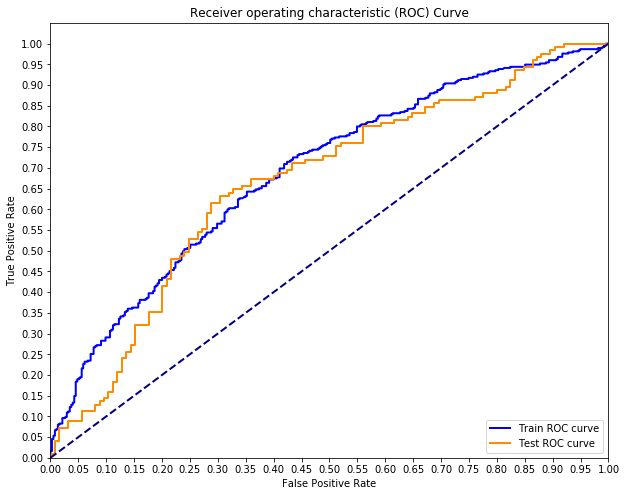

In [20]:
produce_roc_curve(X_train, X_test, y_train, y_test)

A small difference between the training and test AUC scores means higher model accuracy.
 - All predictors (35): ~0.06 
 - Culled predictors (6): ~0.02 
 
A greater psuedo-R-squared means that our model explains more variance in the training set.
- All predictors (35): ~0.08 
- Culled predictors (6): ~0.06

Therefore, our model sacrifices stronger fit - or overfitting - for higher predictive accuracy.

The Test ROC curve shows that TPR increases faster than FPR at low rates. The slope at low rates is more consistent for the model using culled predictors. At high rates, the curve slope decreases, as expected.

The changes in these differences are very small (~0.002), so we will keep the original reegularization parameter.

### Confusion matrix for TRAIN data

In [21]:
predictions = logreg.predict(X_train)
actual = y_train

conf_mat_1 = pd.DataFrame(confusion_matrix(actual, predictions), 
             columns = ['Predicted: Few Likes', 'Predicted: High Likes'], 
             index = ['Actual: Few Likes', 'Actual: High Likes'])
conf_mat_1

,Predicted: Few Likes,Predicted: High Likes
Actual: Few Likes,251,124
Actual: High Likes,149,226


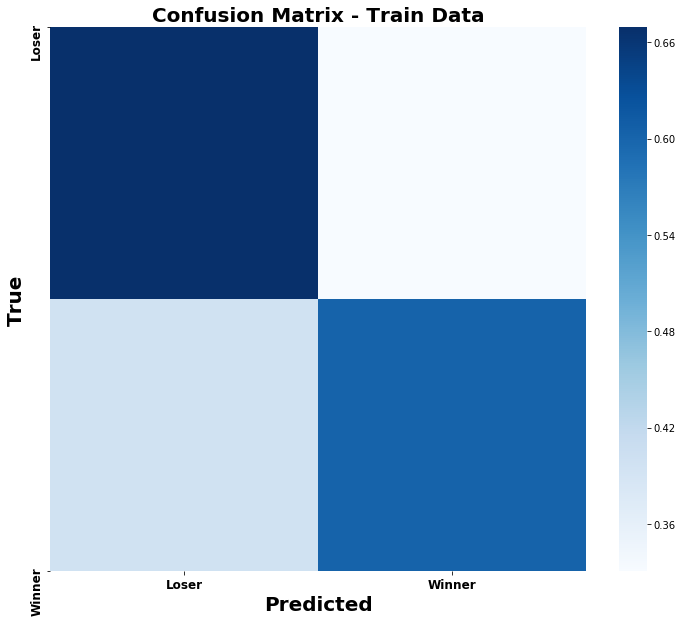

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
cm_1 = conf_mat_1.astype('float') / conf_mat_1.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_1, annot=False, ax = ax, cmap="Blues", cbar=True)
ax.set_xlabel('Predicted', fontsize=20, weight = 'bold');
ax.set_ylabel('True', fontsize=20, weight = 'bold'); 
ax.set_title('Confusion Matrix - Train Data', fontsize=20, weight = 'bold'); 
ax.xaxis.set_ticklabels(['Loser', 'Winner'], fontsize=12, weight = 'bold');
ax.yaxis.set_ticklabels(['Loser', 'Winner'], fontsize=12, weight = 'bold');
plt.show()

**Confusion Matrix Results (TRAIN DATA)**

<b>Out of 750 observations:</b>

- 226 recipes were predicted as a "winner" when it really was a "winner". <b>(True Positives)</b>
- 124 recipes were predicted as a "winner" when it really was a "loser". <b>(False Positives)</b>
- 251 recipes were predicted as a "loser" when it really was a "loser". <b>(True Negatives)</b>
- 149 recipes were predicted as a "loser" when it really was a "winner". <b>(False Negatives)</b>

___

### Confusion matrix for TEST data

In [23]:
predictions_test = logreg.predict(X_test)
actual_test = y_test

conf_mat_2 = pd.DataFrame(confusion_matrix(actual_test, predictions_test), 
             columns = ['Predicted: Few Likes', 'Predicted: High Likes'], 
             index = ['Actual: Few Likes', 'Actual: High Likes'])
conf_mat_2

,Predicted: Few Likes,Predicted: High Likes
Actual: Few Likes,89,36
Actual: High Likes,48,77


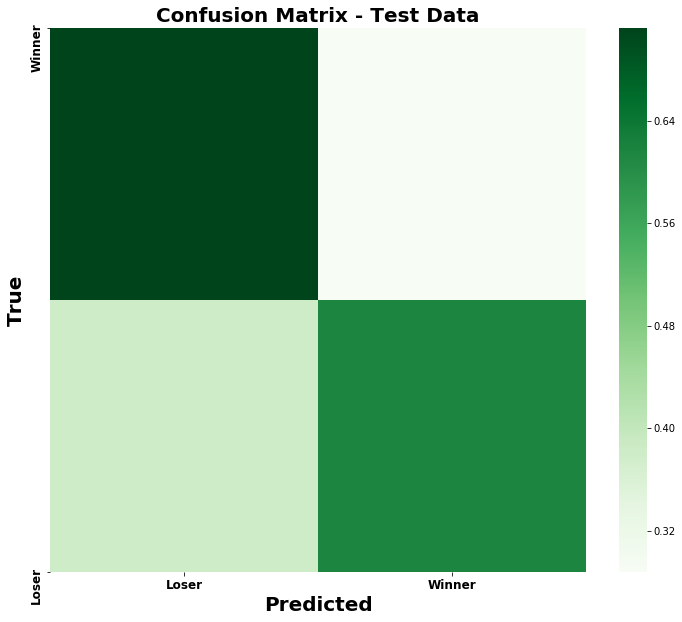

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
cm_2 = conf_mat_2.astype('float') / conf_mat_2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2, annot=False, ax = ax, cmap="Greens", cbar=True)
ax.set_xlabel('Predicted', fontsize=20, weight = 'bold');
ax.set_ylabel('True', fontsize=20, weight = 'bold'); 
ax.set_title('Confusion Matrix - Test Data', fontsize=20, weight = 'bold'); 
ax.xaxis.set_ticklabels(['Loser', 'Winner'], fontsize=12, weight = 'bold');
ax.yaxis.set_ticklabels(['Winner', 'Loser'], fontsize=12, weight = 'bold');
plt.show()
# plt.savefig("matrix.pdf", dpi=300)

**Confusion Matrix Results (TEST DATA)**

<b>Out of 250 observations:</b>

- 77 recipes were predicted as a "winner" when it really was a "winner". <b>(True Positives)</b>
- 36 recipes were predicted as a "winner" when it really was a "loser". <b>(False Positives)</b>
- 89 recipes were predicted as a "loser" when it really was a "loser". <b>(True Negatives)</b>
- 48 recipes were predicted as a "loser" when it really was a "winner". <b>(False Negatives)</b>

___

### Conclusion and Recommendations

- We want to <b>maximize</b> the potential to <b>predict correctly and make money.</b>
- We want to <b>minimize</b> the potential to <b>predict wrong and waste money.</b>
- So, the <b>“precision”</b> of our model is the most important metric to consider.


- Precision = Number Of Good Investments / Total Number Of Investments
- Precision = True Positives / (True Positives + False Positives)
- <b>Precision = 77 / (77 + 36) = 68.1%</b>

<b>With a precision of 68.1% on our test data, for every 3 ads invested, 2 ads will be a good investment and 1 ad may be a loss.<br>
With these odds, we recommend that our clients follow the model to invest in ads on Spoonacular!

___

### Future Improvements For Project

- Obtain web-traffic metrics instead of using “Likes" as a proxy.
- Pull more data from the Spoonacular database.
- Use Natural Language Processing (NLP) to obtain better predictors. 